## Import Cora and Facebook/Page-Page daasets

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import FacebookPagePage

dataset_cora = Planetoid(root="../data", name="Cora")
dataset_facebook = FacebookPagePage(root="../data/Facebook-Page-Page")

data_cora = dataset_cora[0]
data_facebook = dataset_facebook[0]

# Unlike Cora, Facebook Page-Page doesn’t have training, evaluation, and test masks by
# default. We can arbitrarily create masks with the range() function:
data_facebook.train_mask = range(18000)
data_facebook.val_mask = range(18001, 20000)
data_facebook.test_mask = range(20001, 22470)

print(data_cora)
print(data_facebook)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Data(x=[22470, 128], edge_index=[2, 342004], y=[22470], train_mask=[18000], val_mask=[1999], test_mask=[2469])


Cora is a popular dataset for node classification in the scientific literature. It represents a network of 2,708 publications (**nodes**), where each connection is a reference (**edge**). Each publication is described as a binary vector of 1,433 unique words (**node features**), where 0 and 1 indicate the absence or presence of the corresponding word, respectively. Each node has a class label from 7 **classes**.  

## Classifying nodes with vanilla neural networks

We will consider node features (i.e., 1,433) as a regular tabular dataset. We will train a simple neural
network (MLP) on this dataset to classify our nodes. Note that this architecture does not take into account
the topology of the network. We will try to fix this issue with a vanilla GNN and GCN, then compare the results.

In [2]:
import pandas as pd

# This is just to show the feature matrix and class vector (we need torch.Tensor type input --> data_cora.x)
df_x = pd.DataFrame(data_cora.x.numpy()) # 1,433 columns
df_x['label'] = pd.DataFrame(data_cora.y) # adding a label-column
df_x

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        super().__init__()
        self.linear1 = Linear(dim_input, dim_hidden)
        self.linear2 = Linear(dim_hidden, dim_output)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

model_cora = MLP(dataset_cora.num_features, 16, dataset_cora.num_classes)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
model_cora

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)

In [5]:
input = data_cora.x[:1,:]
print(input.shape)
print(model_cora(input))
print(model_cora(input).shape)
print(model_cora(input).argmax(dim=1))

torch.Size([1, 1433])
tensor([[-1.9757, -1.9887, -2.0736, -1.8290, -1.9392, -1.9986, -1.8399]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([1, 7])
tensor([3])


In [6]:
# define a simple accuracy metric (not the best metric for multiclass classification) 
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)
    
criterion = torch.nn.CrossEntropyLoss() # loss
optimizer = torch.optim.Adam(model_cora.parameters(), lr=0.005, weight_decay=5e-4)
num_epochs = 100

In [7]:
# Train MLP model on Cora dataset
model_cora.train()
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    y_pred = model_cora(data_cora.x)
    loss = criterion(y_pred[data_cora.train_mask], data_cora.y[data_cora.train_mask]) # loss = criterion(y_pred, y_true)
    acc = accuracy(y_pred[data_cora.train_mask].argmax(dim=1), data_cora.y[data_cora.train_mask])
    loss.backward()
    optimizer.step()
    if (epoch % 20) == 0:
        val_loss = criterion(y_pred[data_cora.val_mask], data_cora.y[data_cora.val_mask])
        val_acc = accuracy(y_pred[data_cora.val_mask].argmax(dim=1), data_cora.y[data_cora.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}%'
              f'| Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

Epoch   0 | Train Loss: 1.948 | Train Acc: 13.57%| Val Loss: 1.93 | Val Acc: 28.00%
Epoch  20 | Train Loss: 0.490 | Train Acc: 99.29%| Val Loss: 1.59 | Val Acc: 46.80%
Epoch  40 | Train Loss: 0.080 | Train Acc: 100.00%| Val Loss: 1.40 | Val Acc: 53.40%
Epoch  60 | Train Loss: 0.032 | Train Acc: 100.00%| Val Loss: 1.42 | Val Acc: 52.80%
Epoch  80 | Train Loss: 0.020 | Train Acc: 100.00%| Val Loss: 1.42 | Val Acc: 52.60%
Epoch 100 | Train Loss: 0.015 | Train Acc: 100.00%| Val Loss: 1.40 | Val Acc: 52.20%


In [8]:
# Test MLP model on Cora dataset    
model_cora.eval()
y_pred = model_cora(data_cora.x)
acc = accuracy(y_pred[data_cora.test_mask].argmax(dim=1), data_cora.y[data_cora.test_mask])
print(f'\nMLP test accuracy for Cora dataset: {acc*100:.2f}%')


MLP test accuracy for Cora dataset: 52.20%


## Repeat the process for the Facebook Page-Page dataset

In [9]:
model_fb = MLP(dataset_facebook.num_features, 16, dataset_facebook.num_classes)
model_fb

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)

In [10]:
# Train MLP model on Facebook Page-Page dataset
optimizer = torch.optim.Adam(model_fb.parameters(), lr=0.005, weight_decay=5e-4)
model_fb.train()
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    y_pred = model_fb(data_facebook.x)
    train_loss = criterion(y_pred[data_facebook.train_mask], data_facebook.y[data_facebook.train_mask])
    train_acc = accuracy(y_pred[data_facebook.train_mask].argmax(dim=1), data_facebook.y[data_facebook.train_mask])
    train_loss.backward()
    optimizer.step()
    if (epoch % 20) == 0:
        val_loss = criterion(y_pred[data_facebook.val_mask], data_facebook.y[data_facebook.val_mask])
        val_acc = accuracy(y_pred[data_facebook.val_mask].argmax(dim=1), data_facebook.y[data_facebook.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:>5.2f}%'
              f'| Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

Epoch   0 | Train Loss: 1.455 | Train Acc: 17.34%| Val Loss: 1.46 | Val Acc: 18.46%
Epoch  20 | Train Loss: 0.836 | Train Acc: 67.44%| Val Loss: 0.84 | Val Acc: 65.88%
Epoch  40 | Train Loss: 0.640 | Train Acc: 75.01%| Val Loss: 0.66 | Val Acc: 73.94%
Epoch  60 | Train Loss: 0.588 | Train Acc: 76.84%| Val Loss: 0.62 | Val Acc: 75.84%
Epoch  80 | Train Loss: 0.566 | Train Acc: 77.49%| Val Loss: 0.60 | Val Acc: 76.19%
Epoch 100 | Train Loss: 0.553 | Train Acc: 77.93%| Val Loss: 0.60 | Val Acc: 76.24%


In [11]:
# Test MLP model on Facebook Page-Page dataset   
model_fb.eval()
y_pred = model_fb(data_facebook.x)
test_acc = accuracy(y_pred[data_facebook.test_mask].argmax(dim=1), data_facebook.y[data_facebook.test_mask])
print(f'\nMLP test accuracy for Facebook Page-Page dataset: {test_acc*100:.2f}%')


MLP test accuracy for Facebook Page-Page dataset: 75.05%


## Classifying nodes with vanilla graph neural networks

In [12]:
# This is Graph Linear Layer, similar to GCN
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [13]:
class VanillaGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h) # as similar to nn.Linear(dim_in, dim_out)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)
    
    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

### Vanilla GNN for Cora dataset

In [14]:
# Initialize Vanilla GNN for Cora dataset
vanilla_gnn = VanillaGNN(dataset_cora.num_features, 16, dataset_cora.num_classes)
print(vanilla_gnn)

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)


In [15]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data_cora.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [16]:
# Train VanillaGNN model on Cora dataset
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanilla_gnn.parameters(), lr=0.01, weight_decay=5e-4)

vanilla_gnn.train()
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    y_pred = vanilla_gnn(data_cora.x, adjacency)
    train_loss = criterion(y_pred[data_cora.train_mask], data_cora.y[data_cora.train_mask])
    train_acc = accuracy(y_pred[data_cora.train_mask].argmax(dim=1), data_cora.y[data_cora.train_mask])
    train_loss.backward()
    optimizer.step()
    if (epoch % 20) == 0:
        val_loss = criterion(y_pred[data_cora.val_mask], data_cora.y[data_cora.val_mask])
        val_acc = accuracy(y_pred[data_cora.val_mask].argmax(dim=1), data_cora.y[data_cora.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:>5.2f}%'
              f'| Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

Epoch   0 | Train Loss: 2.373 | Train Acc: 24.29%| Val Loss: 2.12 | Val Acc: 21.60%
Epoch  20 | Train Loss: 0.128 | Train Acc: 100.00%| Val Loss: 1.43 | Val Acc: 71.20%
Epoch  40 | Train Loss: 0.020 | Train Acc: 100.00%| Val Loss: 2.00 | Val Acc: 73.60%
Epoch  60 | Train Loss: 0.007 | Train Acc: 100.00%| Val Loss: 2.19 | Val Acc: 73.80%
Epoch  80 | Train Loss: 0.004 | Train Acc: 100.00%| Val Loss: 2.25 | Val Acc: 73.60%
Epoch 100 | Train Loss: 0.003 | Train Acc: 100.00%| Val Loss: 2.27 | Val Acc: 74.00%


In [17]:
# Test VanillaGNN model on Cora dataset
vanilla_gnn.eval()
y_pred = vanilla_gnn(data_cora.x, adjacency)
test_acc = accuracy(y_pred[data_cora.test_mask].argmax(dim=1), data_cora.y[data_cora.test_mask])
print(f'\nVanilla GNN test accuracy for Cora dataset: {test_acc*100:.2f}%')


Vanilla GNN test accuracy for Cora dataset: 75.10%


### Vanilla GNN for Facebook Page-Page dataset

In [18]:
# Initialize Vanilla GNN for Facebook dataset
vanilla_gnn = VanillaGNN(dataset_facebook.num_features, 16, dataset_facebook.num_classes)
print(vanilla_gnn)

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)


In [19]:
adjacency = to_dense_adj(data_facebook.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [20]:
# Train VanillaGNN model on Facebook Page-Page dataset
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vanilla_gnn.parameters(), lr=0.01, weight_decay=5e-4)

vanilla_gnn.train()
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    y_pred = vanilla_gnn(data_facebook.x, adjacency)
    train_loss = criterion(y_pred[data_facebook.train_mask], data_facebook.y[data_facebook.train_mask])
    train_acc = accuracy(y_pred[data_facebook.train_mask].argmax(dim=1), data_facebook.y[data_facebook.train_mask])
    train_loss.backward()
    optimizer.step()
    if (epoch % 20) == 0:
        val_loss = criterion(y_pred[data_facebook.val_mask], data_facebook.y[data_facebook.val_mask])
        val_acc = accuracy(y_pred[data_facebook.val_mask].argmax(dim=1), data_facebook.y[data_facebook.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:>5.2f}%'
              f'| Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

Epoch   0 | Train Loss: 64.449 | Train Acc: 32.49%| Val Loss: 63.00 | Val Acc: 31.77%
Epoch  20 | Train Loss: 6.214 | Train Acc: 77.75%| Val Loss: 3.97 | Val Acc: 78.94%
Epoch  40 | Train Loss: 2.271 | Train Acc: 82.41%| Val Loss: 1.56 | Val Acc: 83.19%
Epoch  60 | Train Loss: 1.334 | Train Acc: 83.00%| Val Loss: 0.97 | Val Acc: 82.44%
Epoch  80 | Train Loss: 0.874 | Train Acc: 83.41%| Val Loss: 0.71 | Val Acc: 83.59%
Epoch 100 | Train Loss: 0.699 | Train Acc: 83.73%| Val Loss: 0.61 | Val Acc: 84.14%


In [21]:
# Test VanillaGNN model on Facebook Page-Page dataset
vanilla_gnn.eval()
y_pred = vanilla_gnn(data_facebook.x, adjacency)
test_acc = accuracy(y_pred[data_facebook.test_mask].argmax(dim=1), data_facebook.y[data_facebook.test_mask])
print(f'\nVanilla GNN test accuracy for Facebook Page-Page dataset: {test_acc*100:.2f}%')


Vanilla GNN test accuracy for Facebook Page-Page dataset: 83.27%


## Graph Convolutional Networks (GCN)

If we look at our Graph Linear layer, we don’t take into account the difference in the number of neighbors. Our layer consists of a simple sum without any normalization coefficient. Imagine that node 1 has 1,000 neighbors and node 2 only has 1: the embedding $ℎ_{1}$ will have much larger values than $ℎ_{2}$. This becomes an issue if we want to compare these embeddings. How are we supposed to make meaningful comparisons when their values are so vastly different? Fortunately, there is a simple solution: dividing the embedding by the number of neighbors.

Kipf and Welling noticed that features from nodes with a lot of neighbors spread very easily, unlike features from more isolated nodes. In the original GCN paper, the authors proposed a hybrid normalization to counterbalance this effect. In practice, they assign higher weights to nodes with few neighbors using the following formula:

$H=\tilde{D}^{-\frac{1}{2}}\tilde{A}^{T}\tilde{D}^{-\frac{1}{2}}XW^{T}$

In [22]:
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.utils import degree

In [23]:
degrees = degree(data_cora.edge_index[0]).numpy()
degrees # degree per node, i.e., 2708

array([3., 3., 5., ..., 1., 4., 4.], dtype=float32)

In [24]:
numbers = Counter(degrees) # counts the frequency of degrees (histogram) as a dictionary
numbers

Counter({2.0: 583,
         3.0: 553,
         1.0: 485,
         4.0: 389,
         5.0: 281,
         6.0: 131,
         7.0: 82,
         8.0: 57,
         10.0: 26,
         9.0: 25,
         12.0: 18,
         11.0: 14,
         17.0: 8,
         16.0: 7,
         14.0: 6,
         15.0: 6,
         19.0: 5,
         13.0: 5,
         21.0: 3,
         18.0: 3,
         23.0: 3,
         32.0: 2,
         30.0: 2,
         36.0: 1,
         78.0: 1,
         33.0: 1,
         29.0: 1,
         34.0: 1,
         26.0: 1,
         168.0: 1,
         22.0: 1,
         42.0: 1,
         74.0: 1,
         44.0: 1,
         31.0: 1,
         65.0: 1,
         40.0: 1})

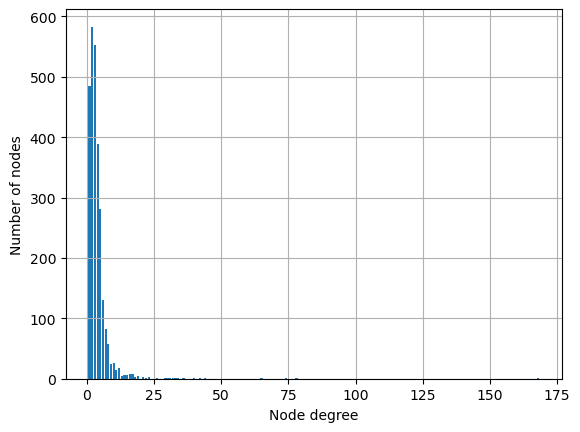

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())
plt.grid()

This distribution looks exponential with a heavy tail: it ranges from 1 neighbor (485 nodes) to 168
neighbors (1 node)! This is exactly the kind of dataset where we want a normalization process to
consider this disbalance.

In [26]:
# Same process is repeated for the Facebook Page-Page dataset
degrees = degree(data_facebook.edge_index[0]).numpy() # degree per node, i.e., 22470
numbers = Counter(degrees)
numbers

Counter({1.0: 2658,
         2.0: 2307,
         3.0: 1843,
         4.0: 1516,
         5.0: 1359,
         6.0: 1114,
         7.0: 974,
         8.0: 811,
         9.0: 731,
         10.0: 618,
         11.0: 555,
         12.0: 494,
         13.0: 452,
         14.0: 391,
         15.0: 380,
         17.0: 348,
         16.0: 333,
         18.0: 316,
         19.0: 265,
         20.0: 264,
         21.0: 233,
         22.0: 227,
         23.0: 213,
         25.0: 200,
         24.0: 193,
         26.0: 192,
         29.0: 151,
         27.0: 149,
         28.0: 145,
         31.0: 132,
         33.0: 130,
         30.0: 127,
         32.0: 112,
         35.0: 107,
         36.0: 107,
         34.0: 102,
         37.0: 89,
         38.0: 85,
         43.0: 76,
         40.0: 74,
         42.0: 70,
         39.0: 70,
         44.0: 69,
         41.0: 67,
         45.0: 59,
         51.0: 54,
         53.0: 53,
         48.0: 52,
         47.0: 51,
         46.0: 49,
         50.0: 48

In [27]:
int(min(numbers)), int(max(numbers))

(1, 709)

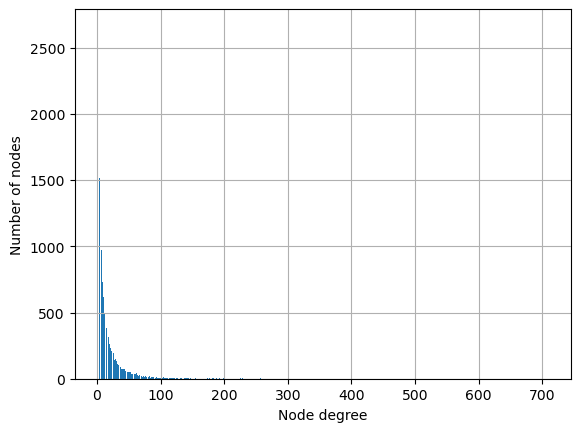

In [28]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())
plt.grid()

This distribution of node degrees looks even more skewed, with a number of neighbors that ranges
from 1 to 709. For the same reason, the Facebook Page-Page dataset is also a good case in which to
apply a GCN.

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [30]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

### GCN for Cora dataset

In [31]:
gcn_cora = GCN(dataset_cora.num_features, 16, dataset_cora.num_classes)
gcn_cora

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)

In [32]:
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)
    
criterion = torch.nn.CrossEntropyLoss() # loss
optimizer = torch.optim.Adam(gcn_cora.parameters(), lr=0.005, weight_decay=5e-4)
num_epochs = 100

In [33]:
# Train GCN model on Cora dataset
gcn_cora.train()
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    y_pred = gcn_cora(data_cora.x, data_cora.edge_index)
    loss = criterion(y_pred[data_cora.train_mask], data_cora.y[data_cora.train_mask]) # loss = criterion(y_pred, y_true)
    acc = accuracy(y_pred[data_cora.train_mask].argmax(dim=1), data_cora.y[data_cora.train_mask])
    loss.backward()
    optimizer.step()
    if (epoch % 20) == 0:
        val_loss = criterion(y_pred[data_cora.val_mask], data_cora.y[data_cora.val_mask])
        val_acc = accuracy(y_pred[data_cora.val_mask].argmax(dim=1), data_cora.y[data_cora.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}%'
              f'| Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

Epoch   0 | Train Loss: 1.938 | Train Acc: 15.00%| Val Loss: 1.94 | Val Acc: 15.00%
Epoch  20 | Train Loss: 0.605 | Train Acc: 90.00%| Val Loss: 1.16 | Val Acc: 64.00%
Epoch  40 | Train Loss: 0.134 | Train Acc: 100.00%| Val Loss: 0.85 | Val Acc: 75.20%
Epoch  60 | Train Loss: 0.045 | Train Acc: 100.00%| Val Loss: 0.77 | Val Acc: 76.00%
Epoch  80 | Train Loss: 0.029 | Train Acc: 100.00%| Val Loss: 0.74 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.025 | Train Acc: 100.00%| Val Loss: 0.73 | Val Acc: 77.00%


In [34]:
# Test GCN model on Cora dataset
gcn_cora.eval()
y_pred = gcn_cora(data_cora.x, data_cora.edge_index)
test_acc = accuracy(y_pred[data_cora.test_mask].argmax(dim=1), data_cora.y[data_cora.test_mask])
print(f'\nGCN test accuracy for Cora dataset: {test_acc*100:.2f}%')


GCN test accuracy for Cora dataset: 79.70%


### GCN for Facebook Page-Page dataset

In [35]:
gcn_fb = GCN(dataset_facebook.num_features, 16, dataset_facebook.num_classes)
gcn_fb

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)

In [36]:
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)
    
criterion = torch.nn.CrossEntropyLoss() # loss
optimizer = torch.optim.Adam(gcn_fb.parameters(), lr=0.005, weight_decay=5e-4)
num_epochs = 100

In [37]:
# Train GCN model on Facebook Page-Page dataset
gcn_fb.train()
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    y_pred = gcn_fb(data_facebook.x, data_facebook.edge_index)
    loss = criterion(y_pred[data_facebook.train_mask], data_facebook.y[data_facebook.train_mask]) # loss = criterion(y_pred, y_true)
    acc = accuracy(y_pred[data_facebook.train_mask].argmax(dim=1), data_facebook.y[data_facebook.train_mask])
    loss.backward()
    optimizer.step()
    if (epoch % 20) == 0:
        val_loss = criterion(y_pred[data_facebook.val_mask], data_facebook.y[data_facebook.val_mask])
        val_acc = accuracy(y_pred[data_facebook.val_mask].argmax(dim=1), data_facebook.y[data_facebook.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}%'
              f'| Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

Epoch   0 | Train Loss: 1.343 | Train Acc: 30.43%| Val Loss: 1.35 | Val Acc: 30.77%
Epoch  20 | Train Loss: 0.636 | Train Acc: 78.84%| Val Loss: 0.63 | Val Acc: 78.94%
Epoch  40 | Train Loss: 0.424 | Train Acc: 85.89%| Val Loss: 0.42 | Val Acc: 86.39%
Epoch  60 | Train Loss: 0.343 | Train Acc: 89.16%| Val Loss: 0.34 | Val Acc: 89.34%
Epoch  80 | Train Loss: 0.306 | Train Acc: 90.25%| Val Loss: 0.30 | Val Acc: 90.20%
Epoch 100 | Train Loss: 0.285 | Train Acc: 90.97%| Val Loss: 0.28 | Val Acc: 91.10%


In [38]:
# Test GCN model on Facebook Page-Page dataset
gcn_fb.eval()
y_pred = gcn_fb(data_facebook.x, data_facebook.edge_index)
test_acc = accuracy(y_pred[data_facebook.test_mask].argmax(dim=1), data_facebook.y[data_facebook.test_mask])
print(f'\nGCN test accuracy for Facebook Page-Page dataset: {test_acc*100:.2f}%')


GCN test accuracy for Facebook Page-Page dataset: 89.83%


## Predicting web traffic with node regression

This dataset is the Wikipedia Network (GNU General Public License v3.0), introduced
by Rozemberckzi et al. in 2019. It is composed of three page-page networks: chameleons (2,277
nodes and 31,421 edges), crocodiles (11,631 nodes and 170,918 edges), and squirrels (5,201 nodes and
198,493 edges). In these datasets, nodes represent articles and edges are mutual links between them.
Node features reflect the presence of particular words in the articles. Finally, the goal is to predict the
log average monthly traffic of December 2018.

We will apply a GCN to predict this traffic on the chameleon dataset.

In [60]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

In [61]:
dataset = WikipediaNetwork(root="../data", name="chameleon",
transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]
data

Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277], val_mask=[2277], test_mask=[2277])

In [62]:
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5


The output shows that we have five classes. However, we want to perform node regression, not classification.
In fact, these five classes are bins of the continuous values we want to predict. Unfortunately,
these labels are not the ones we want. We downloaded
the **wikipedia.zip** file from *https://snap.stanford.edu/
data/wikipedia-article-networks.html*. After unzipping the file, we import
pandas and use it to load the targets.

In [63]:
import pandas as pd
df = pd.read_csv('../data/wikipedia/chameleon/musae_chameleon_target.csv')
df

,id,target
0,0,171
1,1,8089
2,2,8568
3,3,47178
4,4,3634
...,...,...
2272,2272,31418
2273,2273,2716
2274,2274,99
2275,2275,22898


We apply a *log* function to the target values using **np.log10()** because the goal is to predict
the log average monthly traffic.

In [64]:
import numpy as np
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

In [74]:
degrees = degree(data.edge_index[0]).numpy().astype('int32'); print(degrees)
numbers = Counter(degrees)
numbers

[ 5 17 20 ...  1 10 11]


Counter({4: 190,
         1: 172,
         2: 148,
         7: 146,
         5: 144,
         6: 126,
         18: 123,
         3: 122,
         10: 107,
         8: 78,
         11: 78,
         13: 67,
         9: 66,
         12: 62,
         33: 54,
         25: 49,
         14: 34,
         16: 32,
         23: 31,
         29: 31,
         51: 31,
         20: 29,
         52: 24,
         24: 23,
         50: 22,
         31: 22,
         28: 20,
         17: 18,
         72: 16,
         41: 15,
         71: 14,
         57: 11,
         63: 11,
         65: 10,
         30: 10,
         15: 10,
         62: 9,
         19: 9,
         66: 9,
         78: 8,
         53: 8,
         74: 7,
         80: 7,
         64: 7,
         48: 7,
         56: 6,
         38: 6,
         67: 5,
         21: 5,
         70: 5,
         54: 5,
         69: 4,
         73: 3,
         68: 3,
         61: 3,
         22: 3,
         77: 3,
         43: 2,
         81: 2,
         75: 2,
    

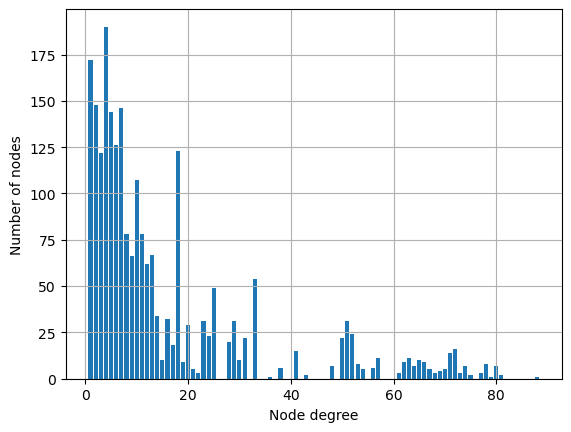

In [75]:
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())
plt.grid()

This distribution has a shorter tail than the previous ones but keeps a similar shape: most nodes have
one or a few neighbors, but some of them act as “hubs” and can connect more than 80 nodes.

In the case of node regression, the distribution of node degrees is not the only type of distribution we
should check: the distribution of our target values is also essential. Indeed, non-normal distribution
(such as node degrees) tends to be harder to predict.

/tmp/ipykernel_450355/2583017776.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['target'], fit=norm)
/home/ctutum/anaconda3/envs/PYTORCHenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='target', ylabel='Density'>

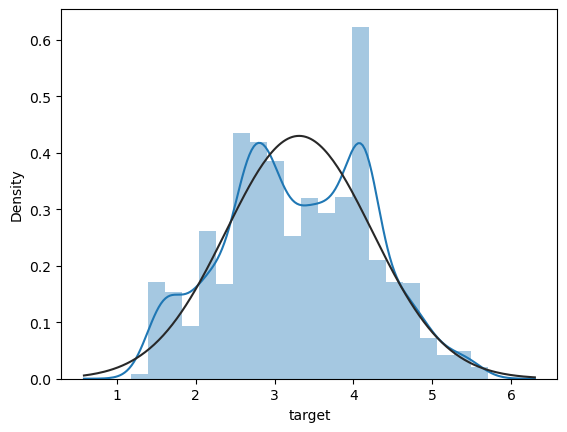

In [81]:
import seaborn as sns
from scipy.stats import norm
df['target'] = values
sns.distplot(df['target'], fit=norm)

This distribution is not exactly normal, but it is not exponential like the node degrees either. We can
expect our model to perform well to predict these values.

In [83]:
# Implement a new GCN model
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

In [86]:
gcn = GCN(data.num_features, 128, 1)
print(gcn)

optimizer = torch.optim.Adam(gcn.parameters(), lr=0.02, weight_decay=5e-4)
num_epochs = 200
gcn.train()
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    y_pred = gcn(data.x, data.edge_index)
    loss = F.mse_loss(y_pred.squeeze()[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        val_loss = F.mse_loss(y_pred.squeeze()[data.val_mask], data.y[data.val_mask])
        print(f"Epoch {epoch:>3} | Train Loss:{loss:.5f} | Val Loss: {val_loss:.5f}")

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss:11.63491 | Val Loss: 11.47501
Epoch  20 | Train Loss:10.66870 | Val Loss: 10.63719
Epoch  40 | Train Loss:4.37252 | Val Loss: 4.47069
Epoch  60 | Train Loss:1.06530 | Val Loss: 1.35093
Epoch  80 | Train Loss:0.65518 | Val Loss: 0.70271
Epoch 100 | Train Loss:0.52248 | Val Loss: 0.69885
Epoch 120 | Train Loss:0.44434 | Val Loss: 0.69830
Epoch 140 | Train Loss:0.42267 | Val Loss: 0.70400
Epoch 160 | Train Loss:0.40020 | Val Loss: 0.64674
Epoch 180 | Train Loss:0.35226 | Val Loss: 0.62482
Epoch 200 | Train Loss:0.35929 | Val Loss: 0.65659


In [89]:
gcn.eval()
y_pred = gcn(data.x, data.edge_index)
loss = F.mse_loss(y_pred.squeeze()[data.test_mask], data.y[data.test_mask].float())
print(f'GCN test loss: {loss:.5f}')

GCN test loss: 0.75580


This **MSE loss** is not the most interpretable metric by itself. We can get more meaningful results using
the two following metrics: **RMSE (Root Mean Square Error)**, measures the average magnitude of the error, and **MAE (Mean Absolute Error)**, which gives the mean absolute difference between the predicted and real values.

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7558 | RMSE = 0.8694 | MAE = 0.6686


These metrics are useful for comparing different models, but it can be difficult to interpret the MSE
and the RMSE.

The best tool to visualize the results of our model is a scatter plot, where the horizontal axis represents
our predictions and the vertical axis represents the real values. Seaborn has a dedicated function
**regplot()** for this type of visualization.

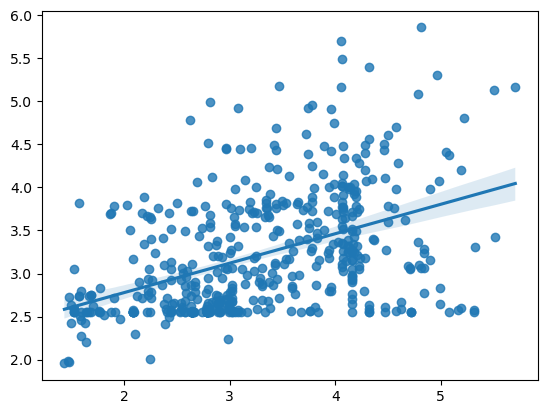

In [91]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)